<a href="https://colab.research.google.com/github/HSE-LAMBDA/mldm-2019/blob/master/day-7/GAN_(WGAN_GP_%2B_conv).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://github.com/yandexdataschool/MLatImperial2019/raw/master/06_lab/lfw_dataset.py

--2019-10-29 15:52:35--  https://github.com/yandexdataschool/MLatImperial2019/raw/master/06_lab/lfw_dataset.py
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/MLatImperial2019/master/06_lab/lfw_dataset.py [following]
--2019-10-29 15:52:35--  https://raw.githubusercontent.com/yandexdataschool/MLatImperial2019/master/06_lab/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2660 (2.6K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.60K  --.-KB/s    in 0s      

2019-10-29 15:52:35 (53.7 MB/s) - ‘lfw_dataset.py’ saved [2660/2660]

In [0]:
!pip install scipy==1.1

     |████████████████████████████████| 31.2MB 37.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [0]:
%tensorflow_version 2.x

In [5]:
import numpy as np
import tensorflow as tf
tf.__version__

'2.0.0'

In [6]:
from lfw_dataset import fetch_lfw_dataset
data, _ = fetch_lfw_dataset(dimx=36, dimy=36)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [7]:
data.shape

(13143, 36, 36, 3)

In [0]:
import matplotlib.pyplot as plt

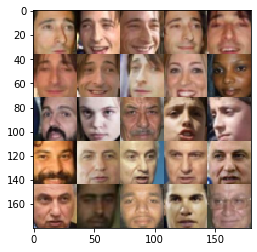

In [9]:
plt.imshow(data[100:125].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));

In [11]:
data.dtype, data.max()

(dtype('uint8'), 255)

In [12]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


In [105]:
ll = tf.keras.layers

LATENT_DIM = 32

generator = tf.keras.Sequential([
  ll.Dense(256, activation='relu', input_shape=(LATENT_DIM,)),
  ll.Reshape((1, 1, 256)),

  ll.UpSampling2D(), # 2x2
  ll.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
  
  ll.UpSampling2D(), # 4x4
  ll.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),

  ll.UpSampling2D(), # 8x8
  ll.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu'), # 6x6

  ll.UpSampling2D(), # 12x12
  ll.Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu'), # 10x10

  ll.UpSampling2D(), # 20x20
  ll.Conv2D(filters=8, kernel_size=3, padding='valid', activation='relu'), # 18x18

  ll.UpSampling2D(), # 36x36
  ll.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
  ll.Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid')

  # ll.Dense(32, input_shape=(LATENT_DIM,), activation='relu'),
  # ll.Dense(64, activation='relu'),
  # ll.Dense(36 * 36 * 3, activation='sigmoid'),
  # ll.Reshape((36, 36, 3)),
])

discriminator = tf.keras.Sequential([
  ll.Conv2D(filters=8, kernel_size=3, padding='same', input_shape=(36, 36, 3)),
  # ll.BatchNormalization(),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 18x18

  ll.Conv2D(filters=16, kernel_size=3, padding='valid'), # 16x16
  # ll.BatchNormalization(),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 8x8

  ll.Conv2D(filters=32, kernel_size=3, padding='same'),
  # ll.BatchNormalization(),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 4x4

  ll.Conv2D(filters=64, kernel_size=3, padding='same'),
  # ll.BatchNormalization(),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 2x2

  ll.Conv2D(filters=128, kernel_size=3, padding='same'),
  # ll.BatchNormalization(),
  ll.ReLU(),
  ll.Dropout(0.1),
  ll.MaxPool2D(), # 1x1

  ll.Reshape((128,)),
  ll.Dense(16),
  # ll.BatchNormalization(),
  ll.ReLU(),
  ll.Dropout(0.1),

  ll.Dense(1)

  # ll.Reshape((36 * 36 * 3,), input_shape=(36, 36, 3)),
  # ll.Dense(64, activation='relu'),
  # ll.Dropout(0.1),
  # ll.Dense(32, activation='relu'),
  # ll.Dropout(0.1),
  # ll.Dense(1),
])

generator.summary()
discriminator.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               8448      
_________________________________________________________________
reshape_44 (Reshape)         (None, 1, 1, 256)         0         
_________________________________________________________________
up_sampling2d_126 (UpSamplin (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 2, 2, 128)         295040    
_________________________________________________________________
up_sampling2d_127 (UpSamplin (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 4, 4, 64)          73792     
_________________________________________________________________
up_sampling2d_128 (UpSamplin (None, 8, 8, 64)        

In [0]:
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))

# @tf.function decorator below compiles the function
# it decorates into a static graph. This improves the performance
# but there are some pitfalls one should be aware of when using it,
# check out https://www.tensorflow.org/tutorials/customization/performance
# for more details
@tf.function
def forward(batch, with_GP):
  real = batch
  fake = gen_images(len(batch))

  loss = tf.reduce_mean(discriminator(fake) - discriminator(real))

  if with_GP:
    alpha = tf.random.uniform(shape=(len(batch), 1, 1, 1))
    interpolates = alpha * real + (1. - alpha) * fake
    with tf.GradientTape() as t:
      t.watch(interpolates)
      int_output = discriminator(interpolates)
    grads = tf.reshape(t.gradient(int_output, interpolates), (len(batch), -1))
    penalty = tf.reduce_mean(tf.maximum(0., tf.norm(grads, axis=1) - 1)**2)
    return loss, penalty
  return loss

opt_d = tf.optimizers.RMSprop(0.001)
opt_g = tf.optimizers.RMSprop(0.001)
GP_FACTOR = 10.


@tf.function
def disc_step(batch):
  with tf.GradientTape() as t:
    loss, penalty = forward(batch, True)
    d_loss = loss + GP_FACTOR * penalty
  grads = t.gradient(d_loss, discriminator.trainable_variables)
  opt_d.apply_gradients(zip(grads, discriminator.trainable_variables))
  for v in discriminator.trainable_variables:
    v.assign(tf.minimum(v, WCLIP))
    v.assign(tf.maximum(v, -WCLIP))
  return loss



@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = -forward(batch, False)
  grads = t.gradient(g_loss, generator.trainable_variables)
  opt_g.apply_gradients(zip(grads, generator.trainable_variables))
  return g_loss


In [0]:
from IPython.display import clear_output
from tqdm import trange

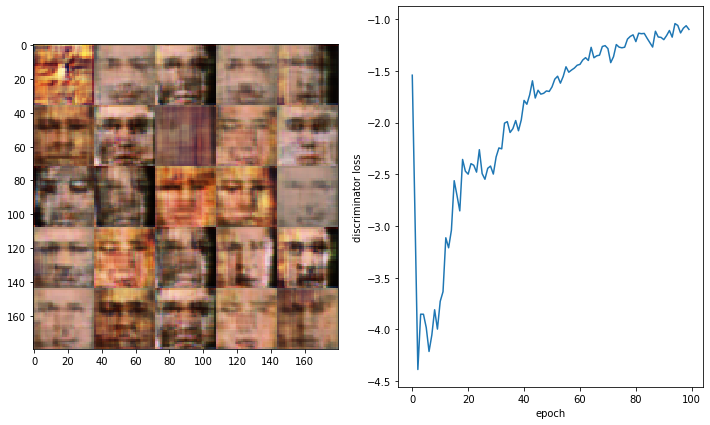

Done with epoch # 99


In [108]:
BATCH_SIZE = 256

N_EPOCHS = 100
NUM_DISC_STEPS = 5

i_disc_step = 0
losses = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss = 0
  tf.keras.backend.set_learning_phase(1) # train
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]

    if i_disc_step < NUM_DISC_STEPS:
      # discriminator update
      i_disc_step += 1
      epoch_loss += disc_step(batch).numpy() * len(batch)
    else:
      i_disc_step = 0
      epoch_loss -= gen_step(batch).numpy() * len(batch)

  epoch_loss /= len(X_train)
  losses.append(epoch_loss)

  opt_d.learning_rate.assign(tf.maximum(0.0001, opt_d.learning_rate * 0.98))
  opt_g.learning_rate.assign(tf.maximum(0.0001, opt_g.learning_rate * 0.98))


  imgs = (gen_images(25).numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses)
  plt.xlabel('epoch')
  plt.ylabel('discriminator loss')
  plt.show()
  print("Done with epoch #", i_ep)

## Excersizes

### 1. Implement a GAN with convolutional layers

### 2. Implement a Wasserstein GAN